# PatchTST Model Development

In this section we will develop the PatchTST model to predict S&P Close, Dow Jones Close.

## Model Congfiguration 

We will configure the PatchTST model based on the `Economic_Data_1994_2025` dataset we processed

In [10]:
from transformers import PatchTSTConfig, PatchTSTForPrediction, PatchTSTForPretraining
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

In [11]:
# For faster development
device = torch.device('mps')
device

device(type='mps')

In [12]:
dataset = pd.read_csv('../data/model_data/PostNorm_Full_Data.csv')
dataset = dataset.drop(['DATE', 'Unnamed: 0'], axis=1)

## Understanding PatchTST

- **Context Length**

    Context length is how far we look back in total. If we were trying to predict the closing price for the SP500 tomorrow, our context length would be how far we look back to make our prediction.

- **Patch Length**

    Patch length is like a subset of our context length. When looking at our entire context length, patch length is the looking at each individual week up until tomorrow to make our final prediction

- **Patch Stride**

    Patch stride is how far our patch length will move after observing an individual week. We can overlap weeks to see any comparisons.
    
For each batch we will pass N amount of rows. Each row has previous rows (context length) attached to it. For each row & it's context length we pass it into our model to train on. During the training process we will used. masked forecasting. This will mask the last portion of our patch's for the model to predict. It then check's it's guesses and updates its weights accordingly.

## PreTraining Model

The pre-training model will learn ***every*** column in our dataset from all dates. This will help the model develop relationships between all variables. 

In [27]:
# How many features we are including 
NUM_INPUT = len(dataset.columns)

# Batch size for training
BATCH_SIZE = 16

# For What we are predicting
NUM_TARGET = 4

# How many steps we take in the context length
CONTEXT_LEN = 120

# How many steps we take in the context length
PATCH_LEN = 20

# How far we move our patch length
PATCH_STRD = 10

# How our model is trained
MASK_TYPE = 'forecast'

# Dimension of the model's internal representations
D_MODEL = 132

# Number of transformer encoder layers (should be multiple of d_model)
# When increased should increase path_dropout.
# default: 3
NUM_HIDD_LAYERS = 4

# Number of parallel attention mechanisms, allows model to focus on different temporal patterns simultaneously (4-8) ideal range
# should divide d model evenly 
#
# larger d_model and more attention heads benefit from higher dropout rates
# default: 4
NUM_ATT_HEAD = 4

# Prevent overfitting by randomly deactivating components, acts as regularization during training
ATT_DROP = .13

# Applies dropout to the feed-forward networks within transformer blocks, 
FF_DROP = .23

# Randomly skips entire layers or sub-pathways during training
# rule of thumb (num_hidden_layers - 2) * .05
PATH_DROP = (NUM_HIDD_LAYERS - 2) * .05

# How many items are masked in our forcast
NUM_PATCH = int(PATCH_LEN * .3) # 30% of our Patch

# Advance Configuring Model
pretrain_config = PatchTSTConfig(
    num_input_channels = NUM_INPUT,
    context_length = CONTEXT_LEN,
    patch_length = PATCH_LEN,
    stride = PATCH_STRD,
    mask_type='forecast',
    num_forecast_mask_patches = NUM_PATCH,
    do_mask_input=True,
    d_model=D_MODEL,
    num_hidden_layers=NUM_HIDD_LAYERS,
    num_attention_heads=NUM_ATT_HEAD,
    attention_dropout=ATT_DROP,
    ff_dropout=FF_DROP,
    path_dropout=PATH_DROP,
)

# Basic Configuration Model
# pretrain_config = PatchTSTConfig(
#     num_input_channels = NUM_INPUT,
#     context_length = CONTEXT_LEN,
#     patch_length = PATCH_LEN,
#     stride = PATCH_STRD,
#     mask_type='forecast',
#     num_forecast_mask_patches = NUM_PATCH,
#     do_mask_input=True,
# )

pretrain_model = PatchTSTForPretraining(pretrain_config)

Here we are splitting up our data into 2 portions. A `test` set and a `train` set. The test set is used to evalute our model based on training from the train set

We split it 80/10/10, where 80% of our data is training data, and 10% of our data is testing, and 10% is validation for each epoch.

In [28]:
# Set up constraints for development
num_train = int(len(dataset) * .7)
num_test = int(len(dataset) * .2)
num_val = int(len(dataset) * .1)

# Breaking up the data into train/test sets.
train = dataset[0: num_train]
test = dataset[num_train:num_test + num_train]
val = dataset[num_test+num_train:(num_test+num_train) + num_val]

This portion here grabs context windows for all rows in our train/test sets

In [29]:
# Creates a context window for each data point to feed into the model during training
def create_sequence_windows(data, window_size):
    windows = []
    
    # We start in the dataFrame at an index 'window_size' and look back depending on the window size
    # We will grab a context window for all data points
    for i in range(len(data) - window_size + 1):
        windows.append(data.iloc[i:i+window_size].values)
    return np.array(windows)

train_windows = create_sequence_windows(train, CONTEXT_LEN)
test_windows = create_sequence_windows(test, CONTEXT_LEN)
val_windows = create_sequence_windows(val, CONTEXT_LEN)

In [30]:
# Puts our data in PyTorch tensors for proper data types during training
past_values_train = torch.tensor(train_windows, dtype=torch.float32)
past_values_test = torch.tensor(test_windows, dtype=torch.float32)
past_values_val = torch.tensor(val_windows, dtype=torch.float32)

Preparing our data to be passed into our model for pre training

In [31]:
# Puts the tensors in a dataset for the dataloader to properly use
data_train = TensorDataset(past_values_train)

# Divides our data into batches based on the BATCH_SIZE
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

data_test = TensorDataset(past_values_test)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE)

data_val = TensorDataset(past_values_val)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE)

In [32]:
pretrain_model = pretrain_model.to(device)

### Pre-Training

Here we are training our model by doing the following:

1. Divide Training into Epoch
    - For each epoch we:
        - Set model to train mode
        - Pass in all of our data one batch size at a time
        - After training on a patch we update our parameters
        - Put our model into evaluation mode
        - Test on our validation set and print results to output
2. Final Train
    - Once we pass through all epochs we do a final test on our
        never seen data, `test` set. 
    - We iterate through our data one batch size at a time and evaluate the model
        one last time

In [33]:
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=.001)

epochs = 15


for epoch in range(epochs):

    # Allows for progress bar during training per epoch
    loop = tqdm(dataloader_train, leave=True)
    losses = []
    
    for batch in loop:
        
        # Puts model in train mode
        pretrain_model.train()
        
        # Clears any previous gradient calculations
        optimizer.zero_grad()
        
        # Transfers batch onto GPU for faster processing
        past_values = batch[0].to(device)
        
        # Foward pass through our model, generates predictions
        outputs = pretrain_model(past_values=past_values)
        
        # Get's the loss for our predictions (how far off our predictions were)
        loss = outputs.loss
        
        # Calculates which weights contributed to the error of our prediction
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(pretrain_model.parameters(), max_norm=3)
        
        # Updates the optimizer based on the calculations made from loss.backward()
        optimizer.step()
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
    
    print("Mean Training Loss", np.mean(losses))
        
    pretrain_model.eval()
    losses = []

    loop = tqdm(dataloader_val, leave=True)
    
    for batch in loop:
        pretrain_model.eval()
        
        past_values = batch[0].to(device)
        
        outputs = pretrain_model(past_values=past_values)
        
        loss = outputs.loss
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
        
    print(f"Mean Training Loss for validation set on EPOCH {epoch} : {np.mean(losses)}")

pretrain_model.eval()
losses = []

loop = tqdm(dataloader_test, leave=True)

for batch in loop:
    
    past_values = batch[0].to(device)
    
    outputs = pretrain_model(past_values=past_values)
    
    loss = outputs.loss
    
    loop.set_description(f'Test')
    loop.set_postfix(loss=loss.item())
    losses.append(loss.item())
    
print(f"Mean Training Loss for test set : {np.mean(losses)}")

Epoch 0: 100%|██████████| 222/222 [02:29<00:00,  1.49it/s, loss=0.198]


Mean Training Loss 0.2622819281443282


Epoch 0: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s, loss=0.0966]


Mean Training Loss for validation set on EPOCH 0 : 0.13899239181325987


Epoch 1: 100%|██████████| 222/222 [02:28<00:00,  1.50it/s, loss=0.104] 


Mean Training Loss 0.12364005867962365


Epoch 1: 100%|██████████| 26/26 [00:04<00:00,  5.84it/s, loss=0.0832]


Mean Training Loss for validation set on EPOCH 1 : 0.10805232622302495


Epoch 2: 100%|██████████| 222/222 [02:28<00:00,  1.50it/s, loss=0.0833]


Mean Training Loss 0.09823174373590732


Epoch 2: 100%|██████████| 26/26 [00:04<00:00,  5.85it/s, loss=0.064] 


Mean Training Loss for validation set on EPOCH 2 : 0.07905014547017905


Epoch 3: 100%|██████████| 222/222 [02:28<00:00,  1.50it/s, loss=0.0772]


Mean Training Loss 0.08132501097547042


Epoch 3: 100%|██████████| 26/26 [00:04<00:00,  5.83it/s, loss=0.0532]


Mean Training Loss for validation set on EPOCH 3 : 0.06717115826904774


Epoch 4: 100%|██████████| 222/222 [02:29<00:00,  1.48it/s, loss=0.0621]


Mean Training Loss 0.07052316464617983


Epoch 4: 100%|██████████| 26/26 [00:04<00:00,  5.80it/s, loss=0.0951]


Mean Training Loss for validation set on EPOCH 4 : 0.07987813193064469


Epoch 5: 100%|██████████| 222/222 [02:30<00:00,  1.48it/s, loss=0.0595]


Mean Training Loss 0.06249091492311375


Epoch 5: 100%|██████████| 26/26 [00:04<00:00,  5.83it/s, loss=0.0474]


Mean Training Loss for validation set on EPOCH 5 : 0.05513558321847366


Epoch 6: 100%|██████████| 222/222 [02:28<00:00,  1.50it/s, loss=0.0568]


Mean Training Loss 0.05518483929336071


Epoch 6: 100%|██████████| 26/26 [00:04<00:00,  5.79it/s, loss=0.0801]


Mean Training Loss for validation set on EPOCH 6 : 0.06178715309271446


Epoch 7: 100%|██████████| 222/222 [02:28<00:00,  1.50it/s, loss=0.0564]


Mean Training Loss 0.04813969623599503


Epoch 7: 100%|██████████| 26/26 [00:04<00:00,  5.80it/s, loss=0.0413]


Mean Training Loss for validation set on EPOCH 7 : 0.043823727478201575


Epoch 8: 100%|██████████| 222/222 [02:29<00:00,  1.49it/s, loss=0.0369]


Mean Training Loss 0.04330549303542923


Epoch 8: 100%|██████████| 26/26 [00:04<00:00,  5.80it/s, loss=0.0528]


Mean Training Loss for validation set on EPOCH 8 : 0.04175261236154116


Epoch 9: 100%|██████████| 222/222 [02:27<00:00,  1.50it/s, loss=0.0453]


Mean Training Loss 0.03854264051292662


Epoch 9: 100%|██████████| 26/26 [00:04<00:00,  5.79it/s, loss=0.0345]


Mean Training Loss for validation set on EPOCH 9 : 0.03545231565546531


Epoch 10: 100%|██████████| 222/222 [02:27<00:00,  1.50it/s, loss=0.0347]


Mean Training Loss 0.03727998987242982


Epoch 10: 100%|██████████| 26/26 [00:04<00:00,  5.82it/s, loss=0.0781]


Mean Training Loss for validation set on EPOCH 10 : 0.05416582696712934


Epoch 11: 100%|██████████| 222/222 [02:27<00:00,  1.50it/s, loss=0.0375]


Mean Training Loss 0.03441753926443624


Epoch 11: 100%|██████████| 26/26 [00:04<00:00,  5.81it/s, loss=0.06]  


Mean Training Loss for validation set on EPOCH 11 : 0.04307905176224617


Epoch 12: 100%|██████████| 222/222 [02:28<00:00,  1.50it/s, loss=0.0237]


Mean Training Loss 0.03349779806359931


Epoch 12: 100%|██████████| 26/26 [00:04<00:00,  5.76it/s, loss=0.0491]


Mean Training Loss for validation set on EPOCH 12 : 0.03994049002917913


Epoch 13: 100%|██████████| 222/222 [02:28<00:00,  1.49it/s, loss=0.0415]


Mean Training Loss 0.03201975785867051


Epoch 13: 100%|██████████| 26/26 [00:04<00:00,  5.79it/s, loss=0.0498]


Mean Training Loss for validation set on EPOCH 13 : 0.04604765149549796


Epoch 14: 100%|██████████| 222/222 [02:28<00:00,  1.50it/s, loss=0.03]  


Mean Training Loss 0.0328673167271657


Epoch 14: 100%|██████████| 26/26 [00:04<00:00,  5.84it/s, loss=0.0493]


Mean Training Loss for validation set on EPOCH 14 : 0.04299611476464914


Test: 100%|██████████| 59/59 [00:10<00:00,  5.46it/s, loss=0.0276]

Mean Training Loss for test set : 0.03824225911018202


In [34]:
torch.save(pretrain_model.state_dict(), 'pt_1*5yn_v2.bin')

### Model Logs

#### Mode: pt_1*5yn_v1

In [ ]:
EPOCH = 15
BATCH_SIZE = 16
NUM_TARGET = 3
CONTEXT_LEN = 150
PATCH_LEN = 10
PATCH_STRD = 5
NUM_PATCH = int(PATCH_LEN * .4) # 40% of our Patch

Mean Training Loss: 0.17927149336850434

Model: pt_1*5yn_v2

In [ ]:
# How many features we are including 
NUM_INPUT = len(dataset.columns)
BATCH_SIZE = 16
EPOCH = 15

NUM_TARGET = 4
CONTEXT_LEN = 120
PATCH_LEN = 20
PATCH_STRD = 10
MASK_TYPE = 'forecast'
D_MODEL = 132
NUM_HIDD_LAYERS = 4
NUM_ATT_HEAD = 4
ATT_DROP = .13
FF_DROP = .23
PATH_DROP = (NUM_HIDD_LAYERS - 2) * .05
NUM_PATCH = int(PATCH_LEN * .3)

Mean Training Loss: 0.03824225911018202

## Fine-Tuning

### Setting Up Model Configurations

In [81]:
NUM_INPUT = 4
NUM_TARGET = 4
CONTEXT_LEN = 120
PATCH_LEN = 20
PATCH_STRD = 10
MASK_TYPE = 'forecast'
D_MODEL = 132
NUM_HIDD_LAYERS = 4
NUM_ATT_HEAD = 4
ATT_DROP = .13
FF_DROP = .23
PATH_DROP = (NUM_HIDD_LAYERS - 2) * .05
NUM_PATCH = int(PATCH_LEN * .3)
BATCH_SIZE = 8

In [95]:
# How many days to predict into the future
PRED_LEN = 3 # One Month Prediction
NUM_TARGET = 4

# Advance Model Configuration 
ft_config = PatchTSTConfig(
    num_input_channels = NUM_INPUT,
    num_targets=NUM_TARGET,
    context_length = CONTEXT_LEN,
    patch_length = PATCH_LEN,
    stride = PATCH_STRD,
    mask_type='forecast',
    num_forecast_mask_patches = NUM_PATCH,
    do_mask_input=True,
    d_model=D_MODEL,
    num_hidden_layers=NUM_HIDD_LAYERS,
    num_attention_heads=NUM_ATT_HEAD,
    attention_dropout=ATT_DROP,
    ff_dropout=FF_DROP,
    path_dropout=PATH_DROP,
    prediction_length=PRED_LEN
)

# # Basic Model Configuration 
# ft_config = PatchTSTConfig(
#     num_input_channels = NUM_INPUT,
#     num_targets=NUM_TARGET,
#     context_length = CONTEXT_LEN,
#     patch_length = PATCH_LEN,
#     patch_stride = PATCH_STRD,
#     prediction_length=PRED_LEN 
# )

features_to_pred = ['^GSPC Close', '^DJI Close', 'ES=F Close', 'YM=F Close']

ft_model = PatchTSTForPrediction(ft_config)

# First, load your saved pretrained model
pretrained_weights = torch.load('./pt_1*5yn_v2.bin')

# Copy weights from the encoder part of the pretrained model
# This will transfer only the compatible weights
prediction_model_dict = ft_model.state_dict()

for name, param in pretrained_weights.items():
    if 'encoder' in name:
        # The encoder part is usually named like 'encoder.xxx' in both models
        if name in prediction_model_dict:
            prediction_model_dict[name] = param
ft_model.load_state_dict(prediction_model_dict)

Setting `do_mask_input` parameter to False.


<All keys matched successfully>

### Preparing Data for Fine-Tuning

In [96]:
# Set up constraints for development
num_train = int(len(dataset) * .7)
num_test = int(len(dataset) * .2)
num_val = int(len(dataset) * .1)

dataset = dataset[features_to_pred]
targ_data = dataset

train_targ = targ_data[0: num_train]
train_feat = dataset[0: num_train]

test_targ = targ_data[num_train:num_test + num_train]
test_feat = dataset[num_train:num_test + num_train]

val_targ = targ_data[num_test+num_train:(num_test+num_train) + num_val]
val_feat = dataset[num_test+num_train:(num_test+num_train) + num_val]

**Getting Target/Input Features**

This part is a little odd. 

- **Input Features**

    To get the target features all we need to do is construct a window that looks at the past N amount of days for each data point.
    We include the features we want to predict which makes it **Self Supervised**. 

- **Output Features**

    What we are doing is getting the actual targets we want to predict and making a future window for just the 2 features. 
    In this case we are looking 90 days into the future, or what the model is predicting, and grabbing those values. This is used 
    for the model to evalute it's prediction

In [97]:
# Creates a context window for each data point to feed into the model during training
def create_sequence_windows(data, window_size):
    windows = []
    
    # We start in the dataFrame at an index 'window_size' and look back depending on the window size
    # We will grab a context window for all data points
    for i in range(len(data) - window_size + 1):
        windows.append(data.iloc[i:i+window_size].values)
    return np.array(windows)

train_feat_windows = create_sequence_windows(train_feat, CONTEXT_LEN)
test_feat_windows = create_sequence_windows(test_feat, CONTEXT_LEN)
val_feat_windows = create_sequence_windows(val_feat, CONTEXT_LEN)

# Remove values at the end that don't have enough future data
train_feat_windows = train_feat_windows[0:len(train_feat_windows) - PRED_LEN]
test_feat_windows = test_feat_windows[0:len(test_feat_windows) - PRED_LEN]
val_feat_windows = val_feat_windows[0:len(val_feat_windows) - PRED_LEN]

In [98]:
# Gets indices for the target variables, starting from where we first start predicting with a full context length
# to the last index that will allow for a full prediction
train_targ_indices = range(CONTEXT_LEN, len(train_feat) - PRED_LEN + 1)
test_targ_indices = range(CONTEXT_LEN, len(test_feat) - PRED_LEN + 1)
val_targ_indices = range(CONTEXT_LEN, len(val_feat) - PRED_LEN + 1)

In [99]:
train_targ_windows = [train_targ.iloc[i:i+PRED_LEN].values for i in train_targ_indices]
test_targ_windows = [test_targ.iloc[i:i+PRED_LEN].values for i in test_targ_indices]
val_targ_windows = [val_targ.iloc[i:i+PRED_LEN].values for i in val_targ_indices]

train_targ_windows = np.array(train_targ_windows)
test_targ_windows = np.array(test_targ_windows )
val_targ_windows = np.array(val_targ_windows)

In [100]:

past_train = torch.tensor(train_feat_windows, dtype=torch.float32)
past_test = torch.tensor(test_feat_windows, dtype=torch.float32)
past_val = torch.tensor(val_feat_windows, dtype=torch.float32)

future_train = torch.tensor(train_targ_windows, dtype=torch.float32)
future_test = torch.tensor(test_targ_windows, dtype=torch.float32)
future_val = torch.tensor(val_targ_windows, dtype=torch.float32)
past_test.shape, future_test.shape

(torch.Size([926, 120, 4]), torch.Size([926, 3, 4]))

In [101]:
train_data = TensorDataset(past_train, future_train)
test_data = TensorDataset(past_test, future_test)
val_data = TensorDataset(past_val, future_val)

dataloader_train = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

### Fine-Tuning Model

In [102]:
device = torch.device('mps')
ft_model = ft_model.to(device)

In [103]:
optimizer = torch.optim.Adam(ft_model.parameters(), lr=.00001)


epochs = 10

for epoch in range(epochs):

    # Allows for progress bar during training per epoch
    loop = tqdm(dataloader_train, leave=True)
    losses = []
    
    for past_values, future_values in loop:
        ft_model.train()
        
        # Clears any previous gradient calculations
        optimizer.zero_grad()
        
        # Transfers batch onto GPU for faster processing
        past_values = past_values.to(device)
        future_values = future_values.to(device)
        
        # Foward pass through our model, generates predictions
        outputs = ft_model(past_values=past_values, future_values=future_values)
        
        # Get's the loss for our predictions (how far off our predictions were)
        loss = outputs.loss
        
        # Calculates which weights contributed to the error of our prediction
        loss.backward()
        
        # Add gradient clipping to scale down calculated gradient
        torch.nn.utils.clip_grad_norm_(ft_model.parameters(), max_norm=.0000001)
        
        # Updates the optimizer based on the calculations made from loss.backward()
        optimizer.step()
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
    
    print("Mean Training Loss", np.nanmean(losses))
        
    ft_model.eval()
    losses = []

    loop = tqdm(dataloader_val, leave=True)
    
    for past_values, future_values in loop:
        
        past_values = past_values.to(device)
        future_values = future_values.to(device)
        
        # Foward pass through our model, generates predictions
        outputs = ft_model(past_values=past_values, future_values=future_values)
        
        loss = outputs.loss
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
        
    print(f"Mean Training Loss for validation set on EPOCH {epoch} : {np.nanmean(losses)}")

ft_model.eval()
losses = []

loop = tqdm(dataloader_test, leave=True)

for past_values, future_values in loop:
    
    past_values = past_values.to(device)
    future_values = future_values.to(device)
    
    # Foward pass through our model, generates predictions
    outputs = ft_model(past_values=past_values, future_values=future_values)
    
    loss = outputs.loss
    
    loop.set_description(f'Test')
    loop.set_postfix(loss=loss.item())
    losses.append(loss.item())
    
print(f"Mean Training Loss for test set : {np.nanmean(losses)}")


  0%|          | 0/444 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 444/444 [00:24<00:00, 17.96it/s, loss=0.452] 


Mean Training Loss 0.30278633377170777


Epoch 0: 100%|██████████| 51/51 [00:00<00:00, 63.80it/s, loss=0.0642]


Mean Training Loss for validation set on EPOCH 0 : 0.25489044569286645


Epoch 1: 100%|██████████| 444/444 [00:22<00:00, 19.56it/s, loss=0.0492]


Mean Training Loss 0.2569689399118091


Epoch 1: 100%|██████████| 51/51 [00:00<00:00, 77.65it/s, loss=0.81]  


Mean Training Loss for validation set on EPOCH 1 : 0.22454940732203277


Epoch 2: 100%|██████████| 444/444 [00:22<00:00, 19.33it/s, loss=0.146] 


Mean Training Loss 0.21865175764269387


Epoch 2: 100%|██████████| 51/51 [00:00<00:00, 103.03it/s, loss=0.06]  


Mean Training Loss for validation set on EPOCH 2 : 0.18072833193867816


Epoch 3: 100%|██████████| 444/444 [00:25<00:00, 17.21it/s, loss=0.0594]


Mean Training Loss 0.18823358548704433


Epoch 3: 100%|██████████| 51/51 [00:00<00:00, 58.98it/s, loss=0.271] 


Mean Training Loss for validation set on EPOCH 3 : 0.152521530056701


Epoch 4: 100%|██████████| 444/444 [00:22<00:00, 19.81it/s, loss=0.0297]


Mean Training Loss 0.16179026420823894


Epoch 4: 100%|██████████| 51/51 [00:00<00:00, 61.47it/s, loss=0.249] 


Mean Training Loss for validation set on EPOCH 4 : 0.13031085229971828


Epoch 5: 100%|██████████| 444/444 [00:24<00:00, 18.50it/s, loss=0.394] 


Mean Training Loss 0.14232880804008124


Epoch 5: 100%|██████████| 51/51 [00:00<00:00, 105.83it/s, loss=0.0133]


Mean Training Loss for validation set on EPOCH 5 : 0.10975068438725144


Epoch 6: 100%|██████████| 444/444 [00:23<00:00, 19.03it/s, loss=0.0886]


Mean Training Loss 0.12557573129238375


Epoch 6: 100%|██████████| 51/51 [00:00<00:00, 59.08it/s, loss=0.181] 


Mean Training Loss for validation set on EPOCH 6 : 0.10203729675827074


Epoch 7: 100%|██████████| 444/444 [00:22<00:00, 19.84it/s, loss=0.0666]


Mean Training Loss 0.1140034791115705


Epoch 7: 100%|██████████| 51/51 [00:00<00:00, 70.55it/s, loss=0.0546]


Mean Training Loss for validation set on EPOCH 7 : 0.08896869935971849


Epoch 8: 100%|██████████| 444/444 [00:24<00:00, 17.88it/s, loss=0.113]  


Mean Training Loss 0.10526431913840005


Epoch 8: 100%|██████████| 51/51 [00:00<00:00, 54.70it/s, loss=0.0822]


Mean Training Loss for validation set on EPOCH 8 : 0.08209802013109713


Epoch 9: 100%|██████████| 444/444 [00:23<00:00, 18.61it/s, loss=0.0217]


Mean Training Loss 0.09691613308061753


Epoch 9: 100%|██████████| 51/51 [00:00<00:00, 106.38it/s, loss=0.0179]


Mean Training Loss for validation set on EPOCH 9 : 0.07576879508355085


Test: 100%|██████████| 116/116 [00:01<00:00, 81.17it/s, loss=0.101] 

Mean Training Loss for test set : 0.36414597441654395


### Export Model

In [64]:
torch.save(ft_model.state_dict(), 'pt_1*5yn_v2_ft_3d_v1.bin')

### Model Log

- **pt_1*5yn_v1_ft_3d_v1** MSE - .11

## Evaluate

### Autoregression

To use this model we will use a method called autoregression. Autoregression is where predictions are based on previous values of the target variable.

The core idea of autoregression is as follows:

1. The model makes an initial prediction

2. We feed this prediction back into our dataset

3. Based on our prediction and previous values, we make another prediction.

What we are doing is creating a feedback loop where we keep making predictions based off prior predictions


In [6]:
from datetime import datetime, timedelta
def next_business_day(date):
    # Add one day initially
    next_date = date + timedelta(days=1)
    
    # Keep adding days until we reach a weekday (Monday-Friday)
    while next_date.weekday() >= 5:  # 5 is Saturday, 6 is Sunday
        next_date = next_date + timedelta(days=1)
        
    return next_date

In [65]:
INPUT_NUM = 4
NUM_TARGET = 4
CONTEXT_LEN = 120
PATCH_LEN = 20
PATCH_STRD = 10
MASK_TYPE = 'forecast'
D_MODEL = 132
NUM_HIDD_LAYERS = 4
NUM_ATT_HEAD = 4
ATT_DROP = .13
FF_DROP = .23
PATH_DROP = (NUM_HIDD_LAYERS - 2) * .05
NUM_PATCH = int(PATCH_LEN * .3)
BATCH_SIZE = 8

In [75]:
import pandas as pd
from datetime import datetime, timedelta

features_to_pred = ['^GSPC Close', '^DJI Close', 'ES=F Close', 'YM=F Close']

# How many days to predict into the future
PRED_LEN = 3 # One Month Prediction

# Advance Model Configuration 
ft_config = PatchTSTConfig(
    num_input_channels = NUM_INPUT,
    num_targets=NUM_TARGET,
    context_length = CONTEXT_LEN,
    patch_length = PATCH_LEN,
    stride = PATCH_STRD,
    d_model=D_MODEL,
    num_hidden_layers=NUM_HIDD_LAYERS,
    num_attention_heads=NUM_ATT_HEAD,
    attention_dropout=ATT_DROP,
    ff_dropout=FF_DROP,
    path_dropout=PATH_DROP,
    prediction_length=PRED_LEN 
)

# Basic Model Configuration 
# ft_config = PatchTSTConfig(
#     num_input_channels = NUM_INPUT,
#     num_targets=NUM_TARGET,
#     context_length = CONTEXT_LEN,
#     patch_length = PATCH_LEN,
#     patch_stride = PATCH_STRD,
#     prediction_length=PRED_LEN 
# )

ft_model = PatchTSTForPrediction(ft_config)
PRIOR_DAYS = 50

# Load in our model
device = torch.device('mps')
state_dict = torch.load('pt_1*5yn_v2_ft_3d_v1.bin')
ft_model.load_state_dict(state_dict)

# Get the normalized economic data
pred_and_original_data = pd.read_csv('../data/model_data/PostNorm_Full_Data.csv')

pred_and_original_data[0:len(pred_and_original_data)]

# Filter out data to only contain features needed and Date for merging
pred_and_original_data = pred_and_original_data[['DATE']+features_to_pred]
pred_and_original_data_50_prior = pred_and_original_data[['DATE']+features_to_pred]

pred_and_original_data_50_prior = pred_and_original_data_50_prior[0:len(pred_and_original_data_50_prior) - PRIOR_DAYS]

# How many predictions we will recursively make
NUM_ITER = 12


# Autoregression
for day in range(NUM_ITER):
    
    ft_model.eval()
    
    # Drop the date for prediction
    df_copy = pred_and_original_data.drop(['DATE'], axis=1)
    df_copy_50 = pred_and_original_data_50_prior.drop(['DATE'], axis=1)
    
    with torch.no_grad():
        # Grab the last instance of CONTEXT_LEN days
        features = df_copy.iloc[-CONTEXT_LEN:].values
        features_50 = df_copy_50.iloc[-CONTEXT_LEN:].values
        
        # Convert to proper format for model
        features = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
        features_50 = torch.tensor(features_50, dtype=torch.float32).unsqueeze(0)

        predictions = ft_model(past_values=features)
        print(predictions)
        predictions_50 = ft_model(past_values=features_50)
        
        forcast = predictions.prediction_outputs
        forcast_50 = predictions_50.prediction_outputs
    
    # Convert predictions back to prior format
    predictions = forcast.squeeze(0).numpy()
    predictions_50 = forcast_50.squeeze(0).numpy()
    
    pred_np = predictions
    pred_np_50 = predictions_50
    
    # Get the last dates in the datasets
    last_date = pd.to_datetime(pred_and_original_data['DATE']).iloc[-1]
    last_date_50 = pd.to_datetime(pred_and_original_data_50_prior['DATE']).iloc[-1]

    # Get the next business day after the last date
    next_date = next_business_day(last_date)
    next_date_50 = next_business_day(last_date_50)

    if last_date.weekday() >= 5:
        last_date = last_date + timedelta(days=1)
        if last_date.weekday >= 5:
            last_date = last_date + timedelta(days=1)
            
    if last_date_50.weekday() >= 5:
        last_date_50 = last_date_50 + timedelta(days=1)
        if last_date_50.weekday >= 5:
            last_date_50 = last_date_50 + timedelta(days=1)

    # Create date range for predictions
    future_dates = pd.date_range(
        start=last_date + timedelta(days=1),
        periods=PRED_LEN,
        freq='B'
    )
    
    
    future_dates_50 = pd.date_range(
        start=last_date_50 + timedelta(days=1),
        periods=PRED_LEN,
        freq='B'
    )
    
    # Create a dataframe of our predictions with their corresponding dates
    pred_df = pd.DataFrame(pred_np, columns=features_to_pred)
    pred_df['DATE'] = future_dates
    
    pred_df_50 = pd.DataFrame(pred_np_50, columns=features_to_pred)
    pred_df_50['DATE'] = future_dates_50

    # Add predictions to dataset
    pred_and_original_data = pd.concat([pred_and_original_data, pred_df], ignore_index=True)
    pred_and_original_data['DATE'] = pd.to_datetime(pred_and_original_data['DATE'])
    
    pred_and_original_data_50_prior = pd.concat([pred_and_original_data_50_prior, pred_df_50], ignore_index=True)
    pred_and_original_data_50_prior['DATE'] = pd.to_datetime(pred_and_original_data_50_prior['DATE'])


PatchTSTForPredictionOutput(loss=None, prediction_outputs=tensor([[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]]), hidden_states=None, attentions=None, loc=tensor([[[1.0585, 1.2555, 1.0457, 1.2482]]]), scale=tensor([[[0.3332, 0.5114, 0.3324, 0.5149]]]))
PatchTSTForPredictionOutput(loss=None, prediction_outputs=tensor([[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]]), hidden_states=None, attentions=None, loc=tensor([[[nan, nan, nan, nan]]]), scale=tensor([[[nan, nan, nan, nan]]]))
PatchTSTForPredictionOutput(loss=None, prediction_outputs=tensor([[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]]), hidden_states=None, attentions=None, loc=tensor([[[nan, nan, nan, nan]]]), scale=tensor([[[nan, nan, nan, nan]]]))
PatchTSTForPredictionOutput(loss=None, prediction_outputs=tensor([[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]]), hidden_states=N

### Converting Predictions back to Base Value

In [68]:
from sklearn.preprocessing import RobustScaler

# Load in unnormalized data and format to match features we are predicting
original_df = pd.read_csv('../data/model_data/PreNorm_Full_Data.csv')
original_df_50 = original_df[0:len(original_df) - PRIOR_DAYS]

original_df = original_df[['DATE'] + features_to_pred]
original_df['DATE'] = pd.to_datetime(original_df['DATE'])

original_df_50 = original_df_50[['DATE'] + features_to_pred]
original_df_50['DATE'] = pd.to_datetime(original_df_50['DATE'])

WINDOW_SIZE = int(365*1.5) # Should be the same size from the one we used to normalize, REFER TO Gather_Historical_Data.ipynb


In [69]:
def norm_data_st(norm_df, df, col, window_size=90):
    denorm_df = norm_df.copy()

    # Offset for getting the proper index for our normalized data
    offset = window_size

    # Moving through each row starting at 
    # window_size and going to df length
    for i in tqdm(range(len(norm_df))):
        original_id = i + offset
        
        window_start = original_id - window_size

        # Grabs data from past
        time_window = df.iloc[window_start:original_id]

        # Grab current time
        current_time = norm_df.iloc[i:i+1]

        # Create scaler on based on window
        robust_scaler = RobustScaler()
        robust_scaler.fit(time_window[col])

        # Apply scaler to current index feature
        denomralized_values = robust_scaler.inverse_transform(current_time[col])
        denorm_df.loc[norm_df.index[i], col] = denomralized_values[0]
    return denorm_df

# Get columns to normalize that doesn't include date.
columns_to_unnormalize = pred_and_original_data.drop(['DATE'], axis=1).columns
unnorm_df = norm_data_st(pred_and_original_data, original_df, columns_to_unnormalize,WINDOW_SIZE) 
unnorm_df_50 = norm_data_st(pred_and_original_data_50_prior, original_df_50, columns_to_unnormalize,WINDOW_SIZE) 

100%|██████████| 5228/5228 [00:06<00:00, 765.79it/s]


### Plot Predictions

In [70]:
import matplotlib.pyplot as plt

def plot_time_frame_x2(year_start, year_end, df, x1, x2):
    df_tf = df[(df['DATE'].dt.year >= year_start) & (df['DATE'].dt.year <= year_end)]

    plt.plot(df_tf['DATE'], df_tf[x1], label=x1)
    plt.plot(df_tf['DATE'], df_tf[x2], label=x2)
    plt.legend()
    plt.show()

In [71]:
import matplotlib.dates as mdates

def plot_time_frame_month(year_start, year_end, month_start, month_end, df1, df2, x1, x2):
    df_tf1 = df1[(df1['DATE'].dt.year >= year_start) & (df1['DATE'].dt.year <= year_end)]
    df_tf1 = df_tf1[(df_tf1['DATE'].dt.month >= month_start) & (df_tf1['DATE'].dt.month <= month_end)]
    
    df_tf2 = df2[(df2['DATE'].dt.year >= year_start) & (df2['DATE'].dt.year <= year_end)]
    df_tf2 = df_tf2[(df_tf2['DATE'].dt.month >= month_start) & (df_tf2['DATE'].dt.month <= month_end)]
    
    plt.plot(df_tf2['DATE'], df_tf2[x1], label=f'{x1} Projection', linestyle='--')
    plt.plot(df_tf2['DATE'], df_tf2[x2], label=f'{x2} Projection', linestyle='--')
    
    plt.plot(df_tf1['DATE'], df_tf1[x1], label=x1)
    plt.plot(df_tf1['DATE'], df_tf1[x2], label=x2)

    plt.legend()
    
    # Set a tick for every day
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    
    plt.xticks(rotation=90)
    plt.grid(True)
    
    plt.tight_layout()  # This helps prevent the rotated labels from being cut off
    plt.show()
    
def plot_time_frame_year(year_start, year_end, df1, df2, x1, x2):
    df_tf1 = df1[(df1['DATE'].dt.year >= year_start) & (df1['DATE'].dt.year <= year_end)]
    
    df_tf2 = df2[(df2['DATE'].dt.year >= year_start) & (df2['DATE'].dt.year <= year_end)]
    
    plt.plot(df_tf2['DATE'], df_tf2[x1], label=f'{x1} Projection', linestyle='--')
    plt.plot(df_tf2['DATE'], df_tf2[x2], label=f'{x2} Projection', linestyle='--')
    
    plt.plot(df_tf1['DATE'], df_tf1[x1], label=x1)
    plt.plot(df_tf1['DATE'], df_tf1[x2], label=x2)

    plt.legend()
    
    # Set a tick for every day
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    
    # plt.xticks(rotation=90)
    
    plt.tight_layout()  # This helps prevent the rotated labels from being cut off
    plt.show()
    
def plot_time_frame_year_x1(year_start, year_end, df1, df2, x1):
    df_tf1 = df1[(df1['DATE'].dt.year >= year_start) & (df1['DATE'].dt.year <= year_end)]
    
    df_tf2 = df2[(df2['DATE'].dt.year >= year_start) & (df2['DATE'].dt.year <= year_end)]
    
    plt.plot(df_tf2['DATE'], df_tf2[x1], label=f'{x1} Projection', linestyle='--')
    
    plt.plot(df_tf1['DATE'], df_tf1[x1], label=x1)

    plt.legend()
    
    # Set a tick for every day
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    
    plt.xticks(rotation=90)
    
    plt.tight_layout()  # This helps prevent the rotated labels from being cut off
    plt.show()

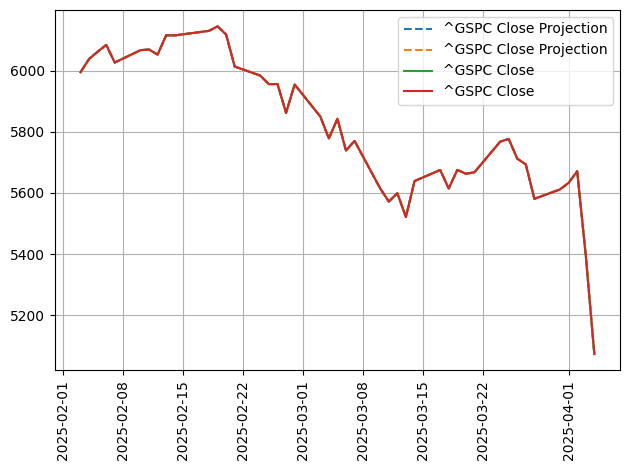

In [74]:
original_df['DATE'] = pd.to_datetime(original_df['DATE'])

plot_time_frame_month(2025, 2025, 2, 4, original_df, unnorm_df, features_to_pred[0], features_to_pred[0])
# plot_time_frame_year_x1(2000, 2025,original_df, unnorm_df, features_to_pred[0])